### Лабораторная работа 3. Имитация систем непрерывных и дискретных случайных величин

In [2]:
%matplotlib notebook

import random
from typing import NamedTuple

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

import sympy as sp
import scipy
import math
from scipy.stats import norm, chi2
import scipy.stats as stats


from IPython.display import display as ipydisplay, Math

In [3]:
USE_CUSTOM_RANDOM_FUNCTION = False

if USE_CUSTOM_RANDOM_FUNCTION:
    lcg_X = 42   # seed
    def lcg():
        global lcg_X
        a = 1103515245
        c = 12345
        m = 2**31
        lcg_X = ((a*lcg_X + c) % m) / m
        return lcg_X
    rand = lcg
else:
    rand = random.random

## Задание 1

Написать программу, реализующую метод формирования двумерной НСВ с определенным распределением.

Выполнить статистическое исследование:
1. Проверить составляющие двумерной НСВ на независимость;
2. Найти условные плотности распределения;
3. Построить гистограммы составляющих двумерной НСВ и графики их плотностей распределения в одной системе координат;
4. Построить гистограмму распределения двумерной НСВ и график плотности распределения в одной системе координат (3D-график);
5. Вычислить теоретические, точечные и интервальные значения характеристик двумерной НСВ (математическое ожидание, дисперсия, корреляция);
6. *Проверить статистические гипотезы о соответствии полученных оценок характеристик (математическое ожидание, дисперсия, корреляция) случайной величины теоретическим.


In [80]:
# Исследуемый закон распределения:

# Вариант 7

# Плотность распределения:

f_str = '0.5 * cos(x-y)'
f_sp = sp.sympify(f_str)
f = sp.lambdify(sp.symbols('x, y'), f_sp)
x_sp, y_sp = sp.symbols('x y')

ipydisplay(Math(f'f(x, y) = {f_sp}'))

<IPython.core.display.Math object>

In [81]:
# Специальный тип для функции плотности и задания границ:

class Pdf2dBundle(NamedTuple):
    pdf: callable
    x1: float
    x2: float
    y1: float
    y2: float

f_bundle = Pdf2dBundle(
    pdf=f,
    x1=0,
    x2=np.pi/2,
    y1=0,
    y2=np.pi/2,
)

In [82]:
# Функция распределения (CDF):

F_sp = sp.integrate(
    f_sp,
    (x_sp, f_bundle.x1, x_sp),
    (y_sp, f_bundle.y1, y_sp),
)
F = sp.lambdify(sp.symbols('x, y'), F_sp)

ipydisplay(Math(f'F(x, y) = {sp.latex(sp.simplify(F_sp))}'))

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


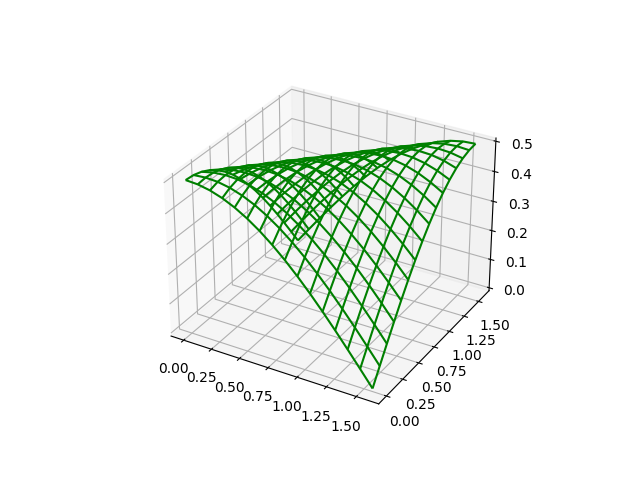

In [6]:
# 3D график плотности распределения

node_count = 16

x_list = np.linspace(
    f_bundle.x1,
    f_bundle.x2,
    node_count,
)
y_list = np.linspace(
    f_bundle.y1,
    f_bundle.y2,
    node_count,
)
X, Y = np.meshgrid(x_list, y_list)
Z = f(X, Y)

fig = plt.figure(label='Плотность распределения')
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='green')

plt.show()

In [7]:
plt.clf()

<IPython.core.display.Javascript object>


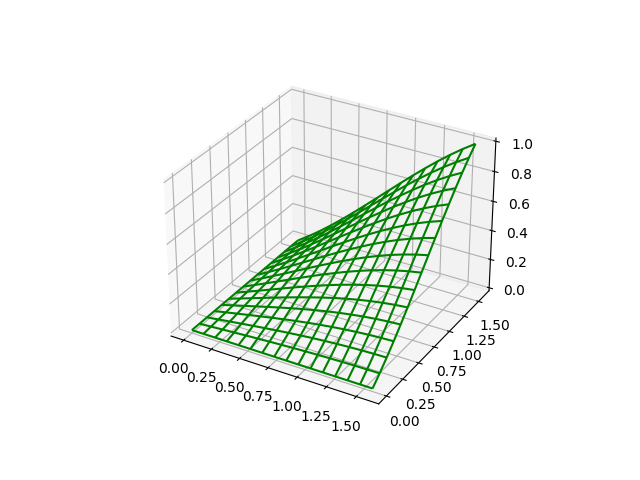

In [40]:
# 3D график функции плотности распределения

Z = F(X, Y)

fig = plt.figure(label='Функция распределения')
ax = plt.axes(projection='3d')
ax.plot_wireframe(
    X, Y, Z,
    color='green',
)

plt.show()

In [41]:
plt.clf()

In [53]:
# Проверка, что значение определенного интеграла функции плотности распределения равно 1:

integral_value = sp.integrate(
    f_sp,
    (x_sp, f_bundle.x1, f_bundle.x2),
    (y_sp, f_bundle.y1, f_bundle.y2),
)

ipydisplay(Math(f'\\int_{{0}}^{{\\pi/2}} \\int_{{0}}^{{\\pi/2}} {f_str} \,dx dy = {round(float(integral_value), 2)}'))

<IPython.core.display.Math object>

### 1. Проверить составляющие двумерной НСВ на независимость

$(f(x, y) = f(x) * f(y) \rightarrow X, Y независимы)$

In [83]:
# Одномерные плотности:

f_x_sp = sp.integrate(
    f_sp,
    (y_sp, f_bundle.x1, f_bundle.x2)
)
f_x = sp.lambdify(
    sp.symbols('x'),
    f_x_sp,
)

f_y_sp = sp.integrate(
    f_sp,
    (x_sp, f_bundle.y1, f_bundle.y2)
)
f_y = sp.lambdify(
    sp.symbols('y'),
    f_y_sp,
)

ipydisplay(Math(f'f(x) = {sp.latex(sp.simplify(f_x_sp))}'))
ipydisplay(Math(f'f(y) = {sp.latex(sp.simplify(f_y_sp))}'))

multiplied_sp = sp.Mul(f_x_sp, f_y_sp)
multiplied = sp.lambdify(sp.symbols('x, y'), multiplied_sp)
ipydisplay(Math(f'f(x)*f(y) = {sp.latex(sp.simplify(multiplied_sp))}'))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


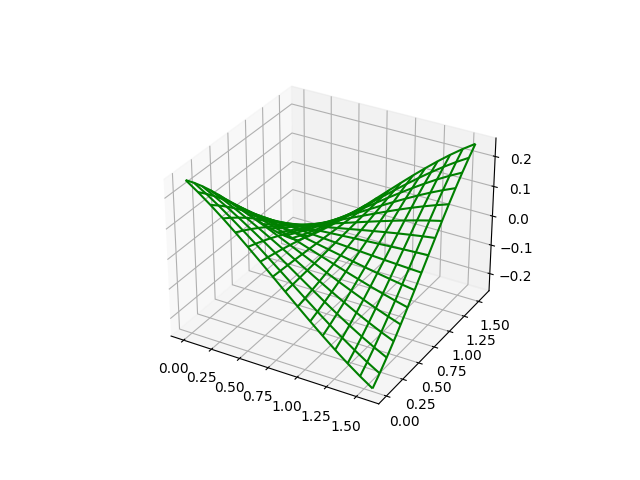

In [55]:
# График разности f(x, y) и f(x)*f(y):

Z = f(X, Y) - multiplied(X, Y)
fig = plt.figure(label='Разность f(x, y) и f(x)*f(y)')
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='green')

plt.show()

### 2. Найти условные плотности распределения

In [84]:
f_x_pipe_y_sp = f_sp / f_y_sp
f_y_pipe_x_sp = f_sp / f_x_sp

ipydisplay(Math(f'f(x | y) = {sp.latex(sp.simplify(f_x_pipe_y_sp))}'))
ipydisplay(Math(f'f(y | x) = {sp.latex(sp.simplify(f_y_pipe_x_sp))}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### 3. Построить гистограммы составляющих двумерной НСВ и графики их плотностей распределения в одной системе координат

In [85]:
# Функция для генерации выборки по функции плотности:

sample_size = 1_000_000

def generate_sample(pdf_bundle: Pdf2dBundle, sample_size=sample_size):
    sample = []
    while len(sample) < sample_size:
        x = pdf_bundle.x1 + rand() * (pdf_bundle.x2 - pdf_bundle.x1)
        y = pdf_bundle.y1 + rand() * (pdf_bundle.y2 - pdf_bundle.y1)
        z = rand()
        if z < pdf_bundle.pdf(x, y):
            sample.append((x, y))
    return sample

In [86]:
# Построение выборки:

sample = generate_sample(f_bundle)
x_sample = [el[0] for el in sample]
y_sample = [el[1] for el in sample]

<IPython.core.display.Javascript object>


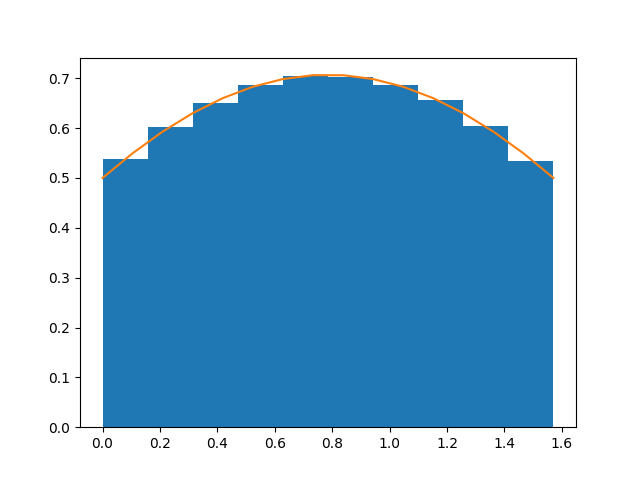

In [67]:
# Построение гистограммы для иксов:

fig = plt.figure(label='Гистограмма 1')

plt.hist(
    x_sample,
    density=True,
    bins=10,
)
plt.plot(
    x_list,
    f_x(x_list),
)
plt.show()

In [70]:
plt.clf()

<IPython.core.display.Javascript object>


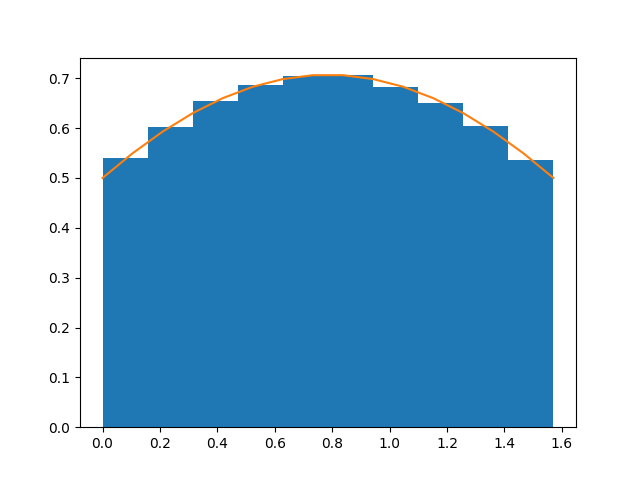

In [72]:
# Построение гистограммы для игреков:

fig = plt.figure(label='Гистограмма 2')

plt.hist(
    y_sample,
    density=True,
    bins=10,
)
plt.plot(
    y_list,
    f_y(y_list),
)
plt.show()

### 4. Построить гистограмму распределения двумерной НСВ и график плотности распределения в одной системе координат (3D-график)

<IPython.core.display.Javascript object>


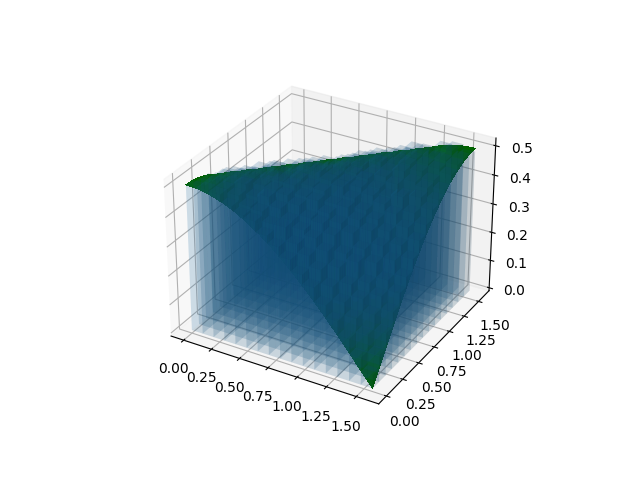

In [87]:
# Двумерная гистограмма + график плотности распределения:

fig = plt.figure(label='Гистограмма выборки + график плотности')
ax = fig.add_subplot(111, projection='3d')

bin_count = 16

x_bin_width = (f_bundle.x2 - f_bundle.x1) / bin_count
y_bin_width = (f_bundle.y2 - f_bundle.y1) / bin_count

hist, x_edges, y_edges = np.histogram2d(
    x_sample, y_sample,
    bins=bin_count,
    range=[
        [f_bundle.x1, f_bundle.x2],
        [f_bundle.y1, f_bundle.y2],
    ],
)

x_pos, y_pos = np.meshgrid(
    x_edges[:-1],
    y_edges[:-1],
)

# Нормализация высот столбцов гистограммы:
hist = hist / sample_size / x_bin_width / y_bin_width
heights = hist.flatten()

ax.bar3d(
    x_pos.flatten(), y_pos.flatten(), np.zeros(len(heights)),
    x_bin_width, y_bin_width, heights,
    alpha=0.1
)
Z = f(X, Y)
ax.plot_surface(
    X, Y, Z,
    color='green',
    antialiased=False
)

plt.show()

### 5. Вычислить теоретические, точечные и интервальные значения характеристик двумерной НСВ

- \+ математическое ожидание
- \+ дисперсия
- \+ среднеквадратическое отклонение
- \+ коэффициент корреляции
- \+ доверительные интервалы для математического ожидания
- \+ доверительные интервалы для дисперсии

In [89]:
# Ожидаемое и наблюдаемое математическое ожидание:

expected_mean = (
    scipy.integrate.dblquad(
        lambda x, y: x * f(x, y),
        f_bundle.x1, f_bundle.x2,
        f_bundle.y1, f_bundle.y2
    )[0],
    scipy.integrate.dblquad(
        lambda x, y: y * f(x, y),
        f_bundle.x1, f_bundle.x2,
        f_bundle.y1, f_bundle.y2
    )[0]
)
observed_mean = (
    np.mean(x_sample),
    np.mean(y_sample),
)

print(f'expected mean: {expected_mean}')
print(f'observed mean: {observed_mean}')

expected mean: (0.7853981633974483, 0.7853981633974483)
observed mean: (0.7859489414183797, 0.7853022708725473)


In [96]:
# Ожидаемая и наблюдаемая дисперсия:

expected_variance = (
    scipy.integrate.dblquad(
        lambda x, y: (x - expected_mean[0])**2 * f(x, y),
        f_bundle.x1, f_bundle.x2,
        f_bundle.y1, f_bundle.y2,
    )[0],
    scipy.integrate.dblquad(
        lambda x, y: (y - expected_mean[1])**2 * f(x, y),
        f_bundle.x1, f_bundle.x2,
        f_bundle.y1, f_bundle.y2,
    )[0],
)

observed_variance = (
    np.var(x_sample),
    np.var(y_sample),
)

print(f'expected variance: {expected_variance}')
print(f'observed variance: {observed_variance}')

print(f'expected standard deviation: {expected_variance[0]**0.5, expected_variance[1]**0.5}')
print(f'observed standard deviation: {observed_variance[0]**0.5, observed_variance[1]**0.5}')

expected variance: (0.18764660186298152, 0.18764660186298154)
observed variance: (0.18747979381524327, 0.1877127509904772)
expected standard deviation: (0.43318195006599886, 0.43318195006599886)
observed standard deviation: (0.4329893691711648, 0.4332582959280494)


In [97]:
# Ожидаемая и наблюдаемая корреляция:

expected_r_xy = scipy.integrate.dblquad(
    lambda x, y: ((x - expected_mean[0]) *
                  (y - expected_mean[1]) *
                  f(x, y)),
    f_bundle.x1, f_bundle.x2,
    f_bundle.y1, f_bundle.y2,
)[0] / np.sqrt(expected_variance[0] * expected_variance[1])

x_sample_centered = x_sample - observed_mean[0]
y_sample_centered = y_sample - observed_mean[1]

observed_r_xy = ((x_sample_centered @ y_sample_centered)
                 / (len(x_sample)
                    * np.sqrt(observed_variance[0]
                              * observed_variance[1])))

print(f'expected r_xy: {expected_r_xy}')
print(f'observed r_xy: {observed_r_xy}')

expected r_xy: 0.245429162137541
observed r_xy: 0.245217917572012


In [106]:
gamma = 0.95 # уровень доверия
hypothesis_error_value = 0.05

# confidence interval
def get_delta(offset):
    t = norm.ppf(gamma / 2 + 0.5) # квантили
    return t * offset / np.sqrt(sample_size) # Margin of Error

def get_offset_delta(test_offset): # build confidence level (хи квадрат)
    alphas = ((1 - gamma) / 2, (1 + gamma) / 2)
    chis = (chi2.isf(alphas, sample_size - 1))
    temp = np.sqrt(sample_size - 1) * test_offset
    
    return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1]))

In [107]:
theoretical_std_deviation_x = expected_variance[0]**0.5
theoretical_std_deviation_y = expected_variance[1]**0.5

sample_std_deviation_x = observed_variance[0]**0.5
sample_std_deviation_y = observed_variance[1]**0.5

delta_x = get_delta(theoretical_std_deviation_x)
delta_y = get_delta(theoretical_std_deviation_y)
offset_delta_x = get_offset_delta(sample_std_deviation_x)
offset_delta_y = get_offset_delta(sample_std_deviation_y)

val_x = np.square(offset_delta_x)
val_y = np.square(offset_delta_y)

print(f'confidence interval x for mean: {observed_mean[0]-delta_x, observed_mean[0]+delta_x}')
print(f'confidence interval y for mean: {observed_mean[1]-delta_y, observed_mean[1]+delta_y}')

print(f'confidence interval x for variance: {val_x}')
print(f'confidence interval y for variance: {val_y}')

confidence interval x for mean: (0.7850999203974975, 0.7867979624392618)
confidence interval y for mean: (0.7844532498516652, 0.7861512918934295)
confidence interval x for variance: [0.18696122 0.18800054]
confidence interval y for variance: [0.18719353 0.18823414]


### 6. *Проверить статистические гипотезы о соответствии полученных оценок характеристик случайной величины теоретическим


In [117]:
chi2_x = (observed_mean[0] - expected_mean[0])**2 / theoretical_std_deviation_x**2

chi2_y = (observed_mean[1] - expected_mean[1])**2 / theoretical_std_deviation_y**2

alpha = 0.05  # Уровень значимости 
df = 1  # Степени свободы 

critical_value = stats.chi2.ppf(1 - alpha, df)
print(f'Chi-squared test for mean x: Chi2 = {chi2_x}, Critical value = {critical_value}')
print(f'Chi-squared test for mean y: Chi2 = {chi2_y}, Critical value = {critical_value}')

# Проверка гипотезы
if chi2_x > critical_value:
    print("Гипотеза о соответствии математического ожидания по x отвергается.")
else:
    print("Гипотеза о соответствии математического ожидания по x принимается.")

if chi2_y > critical_value:
    print("Гипотеза о соответствии математического ожидания по y отвергается.")
else:
    print("Гипотеза о соответствии математического ожидания по y принимается.")

Chi-squared test for mean x: Chi2 = 1.6166369405539027e-06, Critical value = 3.841458820694124
Chi-squared test for mean y: Chi2 = 4.90036922629287e-08, Critical value = 3.841458820694124
Гипотеза о соответствии математического ожидания по x принимается.
Гипотеза о соответствии математического ожидания по y принимается.


In [122]:
chi2_var_x = ((observed_variance[0] * (sample_size - 1)) / (theoretical_std_deviation_x**2)) - (sample_size - 1)

chi2_var_y = ((observed_variance[1] * (sample_size - 1)) / (theoretical_std_deviation_y**2)) - (sample_size - 1)

df = sample_size - 1  

critical_value = stats.chi2.ppf(1 - alpha, df)


if chi2_var_x > critical_value:
    print("Гипотеза о соответствии дисперсии по x отвергается.")
else:
    print("Гипотеза о соответствии дисперсии по x принимается.")

if chi2_var_y > critical_value:
    print("Гипотеза о соответствии дисперсии по y отвергается.")
else:
    print("Гипотеза о соответствии дисперсии по y принимается.")

Гипотеза о соответствии дисперсии по x принимается.
Гипотеза о соответствии дисперсии по y принимается.


## Задание 2

Написать программу, реализующую метод формирования двумерной ДСВ. Матрицу распределения ДСВ задаете самостоятельно.

Выполнить статистическое исследование:
1. Проверить составляющие двумерной ДСВ на независимость;
2. Найти условные плотности распределения;
3. Построить гистограммы составляющих двумерной ДСВ;
4. *Построить гистограмму распределения двумерной ДСВ (3D-график);
5. Вычислить теоретические, точечные и интервальные значения характеристик двумерной ДСВ (математическое ожидание, дисперсия, корреляция);
6. *Проверить статистические гипотезы о соответствии полученных оценок характеристик (математическое ожидание, дисперсия, корреляция) случайной величины теоретическим.

In [4]:
X = [1, 2, 3, 4, 5]
Y = [10, 20, 30, 40, 50]
P = [
        [0, 0, 0.05, 0.05, 0.1],
        [0.025, 0.025, 0.025, 0.025, 0.04],
        [0.05, 0.025, 0, 0, 0.1],
        [0.11, 0.07, 0.03, 0.05, 0.055],
        [0.070, 0.05, 0.05, 0, 0]
]

# Вычисление маргинальных распределений
p_x = [sum(row) for row in P]
p_y = [sum(y) for y in zip(*P)]

# Вычисление условных плотностей распределения
p_yi = [[y / p_x[i] for y in row] for i, row in enumerate(P)]

# Считаем кумулятивную сумму
F_x = np.cumsum(p_x)
F_y = [np.cumsum(p_yi[i]) for i in range(len(Y))]

In [5]:
def get_var_and_index(x, F_x, p):
    '''
    Проходит по списку кумулятивных сумм F_x и 
    находит первый элемент, который больше или равен заданной вероятности p.
    Возвращает значение случайной величины (X или Y) 
    и индекс этого значения в списке.
    '''
    return next((x[i], i) for i, p_ in enumerate(F_x) if p_ >= p)

n = 10000

x_l, y_l = [], []
for _ in range(n):
    x, i = get_var_and_index(X, F_x, rand())
    x_l.append(x)
    y_l.append(get_var_and_index(Y, F_y[i], rand())[0])
    
p_x_imp = [x_l.count(X[i]) / n for i in range(len(X))]
p_y_imp = [y_l.count(Y[i]) / n for i in range(len(Y))]

In [6]:
r_theo = lambda M_xy, M_x, M_y, D_x, D_y: (M_xy - M_x * M_y) / math.sqrt(D_x * D_y)


M_f = lambda v, p_v: sum([v[i] * p_v[i] for i in range(len(v))])

def D_f(v, p_v, M=None):
    if M is None:
        M = M_f(v, p_v)
    return sum([(v[i] ** 2) * p_v[i] for i in range(len(v))]) - M ** 2

M_x = M_f(X, p_x)
M_y = M_f(Y, p_y)
M_xy = sum([
    sum([x * y * P[i][j] for j, y in enumerate(Y)])
    for i, x in enumerate(X)
])
D_x = D_f(X, p_x, M_x)
D_y = D_f(Y, p_y, M_y)

print('Теоретические характеристики')
print('M[x] =', M_x, 'D[x] =', D_x)
print('M[y] =', M_y, 'D[y] =', D_y)
print('r[xy] =', r_theo(M_xy, M_x, M_y, D_x, D_y))
print()
print('Эмпирические характеристики')
print('M[x] =', M_f(X, p_x_imp), 'D[x] =', D_f(X, p_x_imp))
print('M[y] =', M_f(Y, p_y_imp), 'D[y] =', D_f(Y, p_y_imp))
print('r =', stats.pearsonr(x_l, y_l)[0])


Теоретические характеристики
M[x] = 3.115 D[x] = 1.9217749999999985
M[y] = 30.35 D[y] = 249.37749999999994
r[xy] = -0.47690403306892665

Эмпирические характеристики
M[x] = 3.1075 D[x] = 1.9413437499999997
M[y] = 30.487000000000002 D[y] = 244.152831
r = -0.47734432758765716


<IPython.core.display.Javascript object>


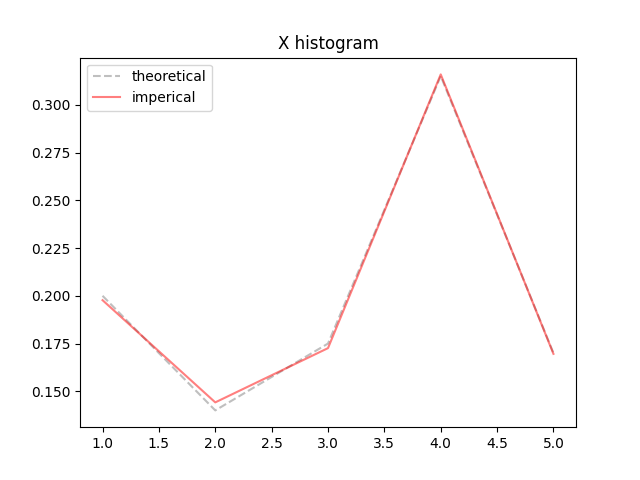

In [15]:
draw_plot(X, p_x, p_x_imp, 'X')

In [7]:
def draw_plot(v, p_v, p_v_imp, var_name):
    plt.plot(v, p_v, label='theoretical', color='gray', alpha=0.5, ls='--')
    plt.plot(v, p_v_imp, label=f'imperical', color='r', alpha=0.5)
    plt.title(f'{var_name} histogram')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


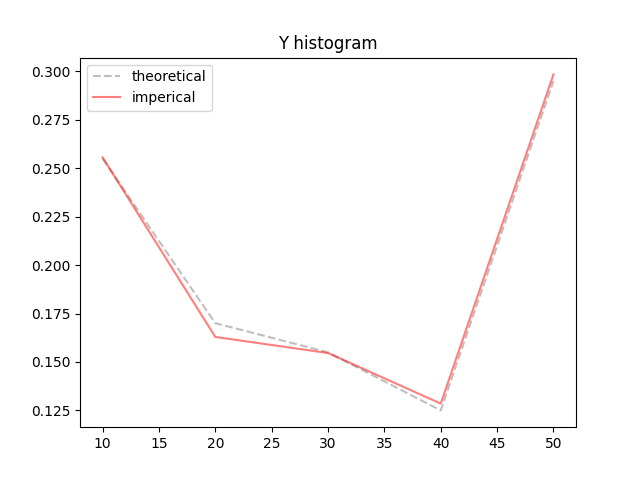

In [11]:
draw_plot(Y, p_y, p_y_imp, 'Y')

<IPython.core.display.Javascript object>


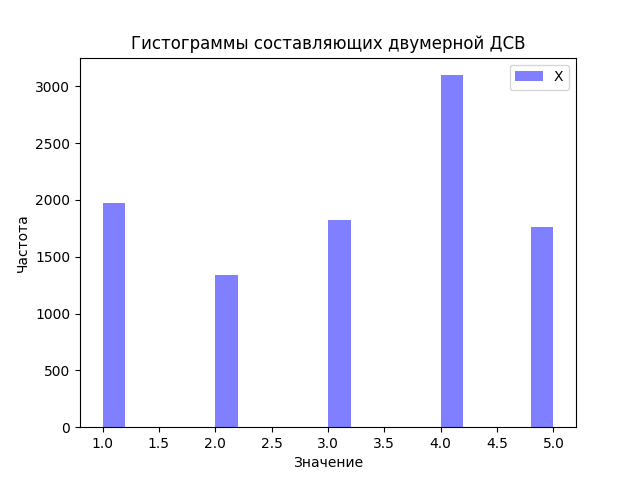

In [10]:
plt.hist(x_l, bins=20, alpha=0.5, color='b', label='X')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.legend()
plt.title('Гистограммы составляющих двумерной ДСВ')
plt.show()

<IPython.core.display.Javascript object>


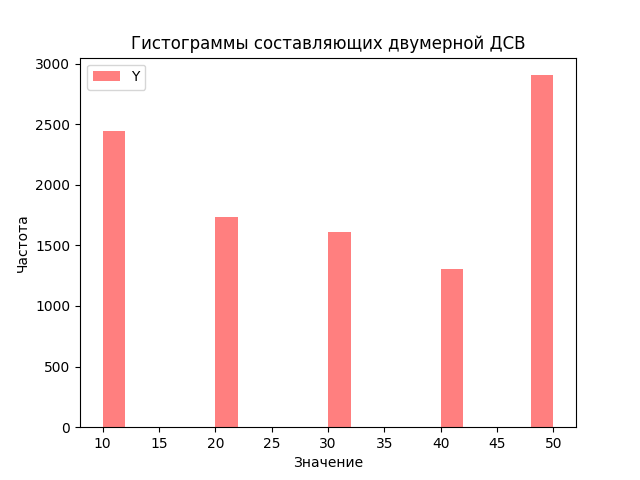

In [7]:
plt.hist(y_l, bins=20, alpha=0.5, color='r', label='Y')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.legend()
plt.title('Гистограммы составляющих двумерной ДСВ')
plt.show()

<IPython.core.display.Javascript object>


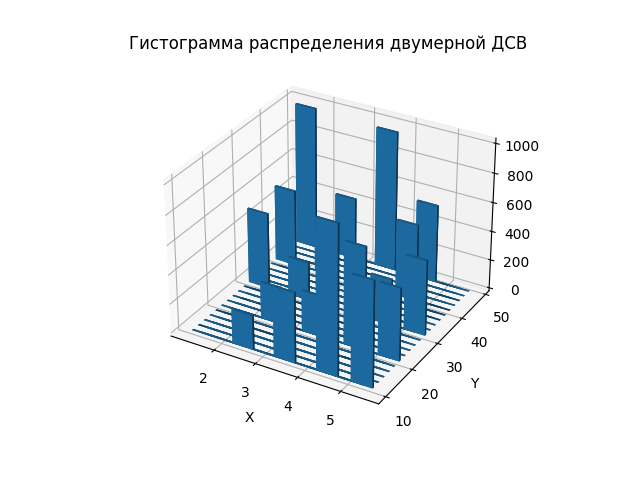

In [8]:
# 3D-график распределения двумерной ДСВ
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(x_l, y_l, bins=20)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")

xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', cmap=cm.viridis)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Гистограмма распределения двумерной ДСВ')
plt.show()

In [9]:
independent = True
for i in range(len(X)):
    for j in range(len(Y)):
        joint_prob = P[i][j]
        marginal_prob = p_x[i] * p_y[j]
        if not np.isclose(joint_prob, marginal_prob):
            independent = False
            break
    if not independent:
        break

if independent:
    print("Компоненты X и Y независимы")
else:
    print("Компоненты X и Y не являются независимыми")

Компоненты X и Y не являются независимыми


In [12]:
def conditional_density_X_given_Y(y):
    index_y = Y.index(y)
    conditional_probs = [P[index_y][i] / p_y[index_y] for i in range(len(X))]
    return conditional_probs

def conditional_density_Y_given_X(x):
    conditional_probs = [P[i][X.index(x)] / p_x[i] if x in X else 0 for i in range(len(Y))]
    return conditional_probs


# Найти условную плотность P(X|Y=30) и P(Y|X=3)
conditional_density_X_given_Y_30 = conditional_density_X_given_Y(30)
conditional_density_Y_given_X_3 = conditional_density_Y_given_X(3)

print("Условная плотность P(X|Y=30):", conditional_density_X_given_Y_30)
print("Условная плотность P(Y|X=3):", conditional_density_Y_given_X_3)

Условная плотность P(X|Y=30): [0.32258064516129026, 0.16129032258064513, 0.0, 0.0, 0.6451612903225805]
Условная плотность P(Y|X=3): [0.25, 0.17857142857142858, 0.0, 0.09523809523809523, 0.29411764705882354]


In [13]:
observed_mean_x = M_f(X, p_x_imp)
observed_mean_y = M_f(Y, p_y_imp)
expected_mean_x = M_x
expected_mean_y = M_y

chi_squared_x = ((observed_mean_x - expected_mean_x) ** 2) / D_x
chi_squared_y = ((observed_mean_y - expected_mean_y) ** 2) / D_y

degrees_of_freedom = 1

alpha = 0.05
critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

if chi_squared_x > critical_value:
    print("Отклоняем нулевую гипотезу для мат. ожидания X")
else:
    print("Нет оснований отклонять нулевую гипотезу для мат. ожидания X")

if chi_squared_y > critical_value:
    print("Отклоняем нулевую гипотезу для мат. ожидания Y")
else:
    print("Нет оснований отклонять нулевую гипотезу для мат. ожидания Y")

Нет оснований отклонять нулевую гипотезу для мат. ожидания X
Нет оснований отклонять нулевую гипотезу для мат. ожидания Y


In [14]:
observed_variance_x =  D_f(X, p_x_imp)  
observed_variance_y = D_f(Y, p_y_imp)  

expected_variance_x = D_x  # Теоретическая дисперсия для X
expected_variance_y = D_y  # Теоретическая дисперсия для Y

n = len(X)  
degrees_of_freedom = n - 1  
chi_squared_x = ((n - 1) * observed_variance_x) / expected_variance_x
chi_squared_y = ((n - 1) * observed_variance_y) / expected_variance_y

alpha = 0.05

critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

if chi_squared_x > critical_value:
    print("Отклоняем нулевую гипотезу для дисперсии X")
else:
    print("Нет оснований отклонять нулевую гипотезу для дисперсии X")

if chi_squared_y > critical_value:
    print("Отклоняем нулевую гипотезу для дисперсии Y")
else:
    print("Нет оснований отклонять нулевую гипотезу для дисперсии Y")

Нет оснований отклонять нулевую гипотезу для дисперсии X
Нет оснований отклонять нулевую гипотезу для дисперсии Y


In [15]:
observed_correlation = np.corrcoef(x_l, y_l)[0, 1] 
expected_correlation = r_theo(M_xy, M_x, M_y, D_x, D_y)

n = len(x_l) 
degrees_of_freedom = 1  
chi_squared = n * (observed_correlation - expected_correlation) ** 2

alpha = 0.05

critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

if chi_squared > critical_value:
    print("Отклоняем нулевую гипотезу для корреляции")
else:
    print("Нет оснований отклонять нулевую гипотезу для корреляции")

Нет оснований отклонять нулевую гипотезу для корреляции
